In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc,precision_score,f1_score,precision_score,make_scorer

In [2]:
import Models

In [3]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [4]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [5]:
for col in embedded_cols:
    df[col] = df[col].apply(Models.convert_to_array)

In [6]:
X = Models.flatten(df)

## PCA

In [7]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

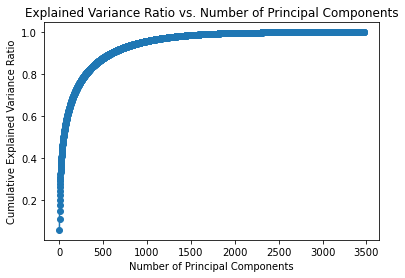

In [8]:
X_pca = Models.do_pca(X_std)

In [9]:
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
variance_first_100 = explained_variance.sum()
print(f"Variance explained by first 100 components: {variance_first_100:.3f}")

Variance explained by first 100 components: 0.618


## Train-Test Split

In [11]:
df1 = pd.DataFrame(X_pca)
y = df['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 100)
(2132, 100)
(8524,)
(2132,)


In [12]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

Counts of label '1' in training data: 588
Counts of label '0' in training data: 7936


## Resampling

In [13]:
X_train_ros, y_train_ros = Models.resampling_method('Oversampling',X_train,y_train)

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64


In [14]:
X_train_rus, y_train_rus = Models.resampling_method('Undersampling',X_train,y_train)

Resampled class counts:
0    588
1    588
Name: Fraudulent, dtype: int64


## Logistic regression (without tuning)

In [18]:
logistic_model = LogisticRegression(solver='liblinear',random_state = 4263)

logistic_model.fit(X_train_ros, y_train_ros)

# Make predictions
y_pred = logistic_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1990
           1       0.40      0.88      0.55       142

    accuracy                           0.90      2132
   macro avg       0.70      0.89      0.75      2132
weighted avg       0.95      0.90      0.92      2132



{'accuracy': 0.9038461538461539,
 'precision': 0.3993610223642173,
 'recall': 0.8802816901408451,
 'f1_score': 0.5494505494505495}

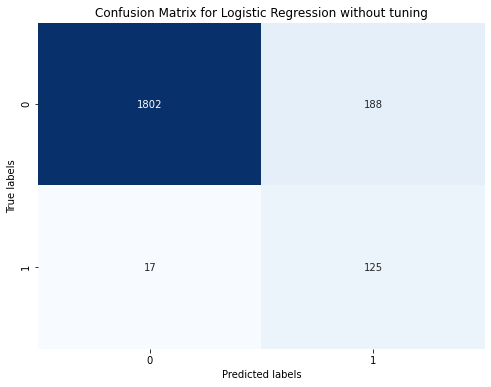

In [15]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression without tuning')

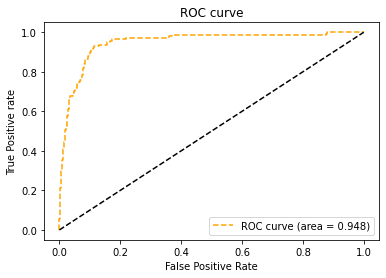

AUC score: 0.948


In [16]:
Models.auc_roc(logistic_model,'Logistic Regression without tuning',X_test,y_test)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1990
           1       0.34      0.89      0.49       142

    accuracy                           0.88      2132
   macro avg       0.67      0.88      0.71      2132
weighted avg       0.95      0.88      0.90      2132



{'accuracy': 0.8785178236397748,
 'precision': 0.34146341463414637,
 'recall': 0.8873239436619719,
 'f1_score': 0.4931506849315069}

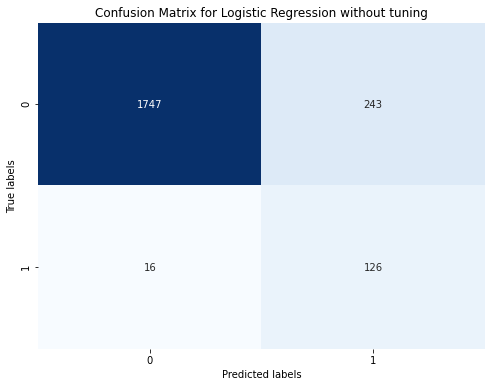

In [22]:
logistic_model.fit(X_train_rus, y_train_rus)

# Make predictions
y_pred = logistic_model.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Logistic Regression without tuning')

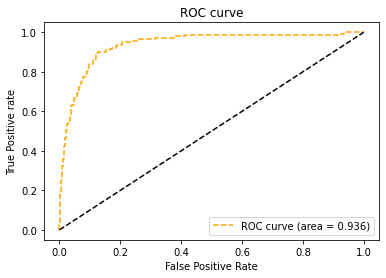

AUC score: 0.936


In [23]:
Models.auc_roc(logistic_model,'Logistic Regression without tuning',X_test,y_test)

## Logistic regression (with tuning)

In [19]:
f1_scorer = make_scorer(f1_score)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # L1 (Lasso) or L2 (Ridge) regularization
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(logistic_model, 
                           param_grid, 
                           cv=5, 
                           scoring= f1_scorer,
                           n_jobs=-1)
grid_search.fit(X_train_ros,y_train_ros)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 0.9078235997246263
Test Accuracy: 0.8921200750469043


              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1990
           1       0.37      0.90      0.53       142

    accuracy                           0.89      2132
   macro avg       0.68      0.90      0.73      2132
weighted avg       0.95      0.89      0.91      2132



{'accuracy': 0.8921200750469043,
 'precision': 0.37209302325581395,
 'recall': 0.9014084507042254,
 'f1_score': 0.5267489711934157}

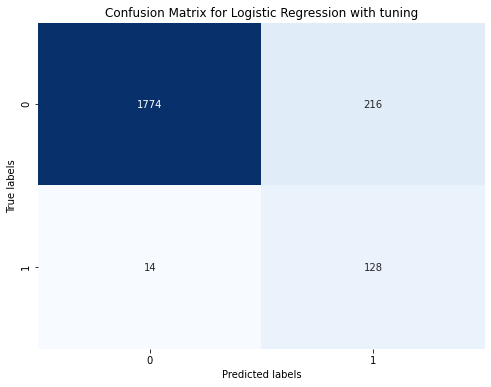

In [20]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression with tuning')

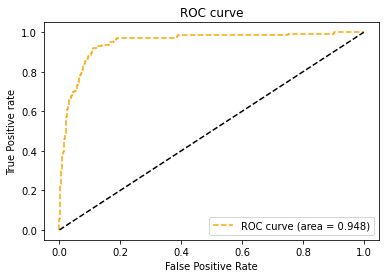

AUC score: 0.948


In [21]:
Models.auc_roc(best_model,'Logistic Regression with tuning',X_test,y_test)

In [24]:
grid_search.fit(X_train_rus,y_train_rus)
# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Best Accuracy: 0.8671692021632971
Test Accuracy: 0.8672607879924953


              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1990
           1       0.32      0.89      0.47       142

    accuracy                           0.87      2132
   macro avg       0.66      0.88      0.70      2132
weighted avg       0.95      0.87      0.89      2132



{'accuracy': 0.8672607879924953,
 'precision': 0.32151898734177214,
 'recall': 0.8943661971830986,
 'f1_score': 0.4729981378026071}

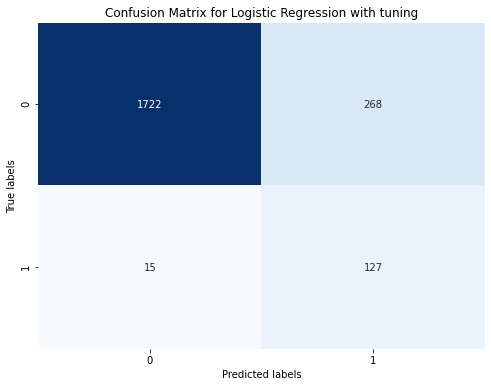

In [25]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression with tuning')

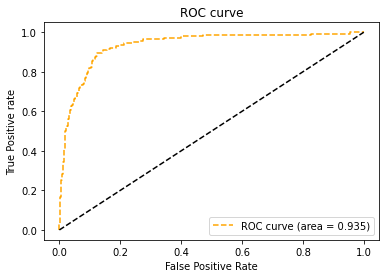

AUC score: 0.935


In [26]:
Models.auc_roc(best_model,'Logistic Regression with tuning',X_test,y_test)

## Decision Tree (without tuning)

In [15]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_ros, y_train_ros)
y_pred_dt = model_dt.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1990
           1       0.56      0.48      0.52       142

    accuracy                           0.94      2132
   macro avg       0.76      0.73      0.74      2132
weighted avg       0.94      0.94      0.94      2132



{'accuracy': 0.9404315196998124,
 'precision': 0.5619834710743802,
 'recall': 0.4788732394366197,
 'f1_score': 0.5171102661596958}

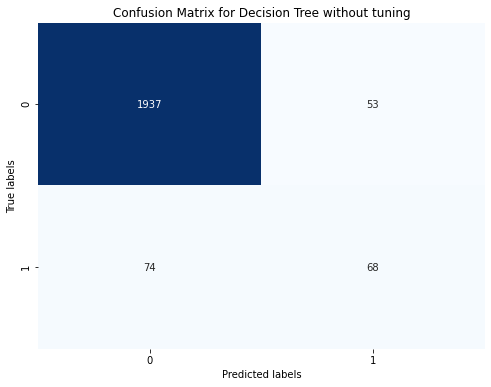

In [17]:
Models.evaluate_model(y_test, y_pred_dt, 'Decision Tree without tuning')

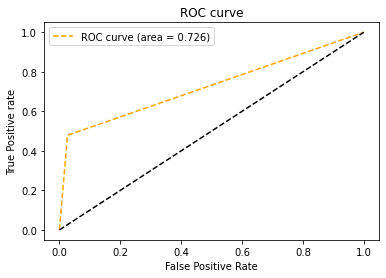

AUC score: 0.726


In [18]:
Models.auc_roc(model_dt,'Decision tree',X_test,y_test)

In [19]:
model_dt.fit(X_train_rus, y_train_rus)
y_pred_dt = model_dt.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1990
           1       0.24      0.80      0.36       142

    accuracy                           0.81      2132
   macro avg       0.61      0.81      0.63      2132
weighted avg       0.93      0.81      0.86      2132



{'accuracy': 0.8128517823639775,
 'precision': 0.23505154639175257,
 'recall': 0.8028169014084507,
 'f1_score': 0.36363636363636365}

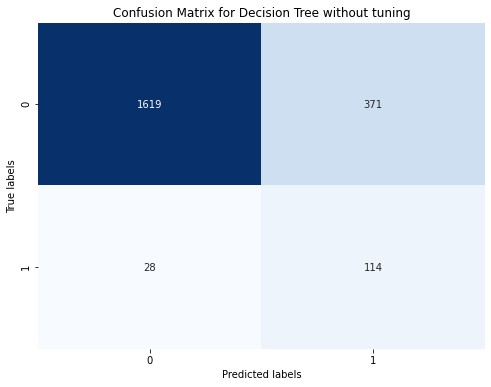

In [20]:
Models.evaluate_model(y_test, y_pred_dt, 'Decision Tree without tuning')

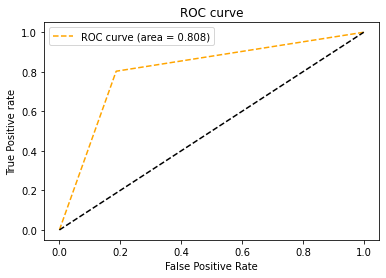

AUC score: 0.808


In [21]:
Models.auc_roc(model_dt,'Decision tree',X_test,y_test)

## Decision Tree (with tuning)

In [23]:
from sklearn.model_selection import GridSearchCV

#Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, 15], #avoid overfitting
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 5, 10],   
    'criterion': ['gini', 'entropy']
}

model_dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(model_dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_ros, y_train_ros)

#best
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1990
           1       0.54      0.51      0.52       142

    accuracy                           0.94      2132
   macro avg       0.75      0.74      0.74      2132
weighted avg       0.94      0.94      0.94      2132



{'accuracy': 0.9380863039399625,
 'precision': 0.5373134328358209,
 'recall': 0.5070422535211268,
 'f1_score': 0.5217391304347826}

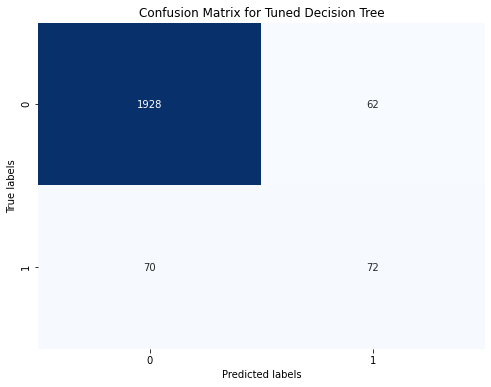

In [24]:
best_model_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
best_model_dt.fit(X_train_ros, y_train_ros)
y_pred_dt_best = best_model_dt.predict(X_test)

Models.evaluate_model(y_test, y_pred_dt_best, 'Tuned Decision Tree')

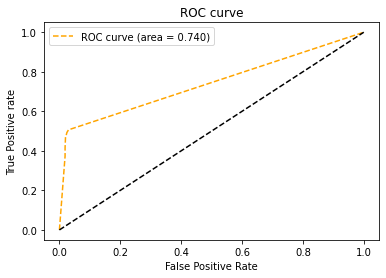

AUC score: 0.74


In [26]:
Models.auc_roc(best_model_dt,'Decision tree',X_test,y_test)

In [27]:
grid_search.fit(X_train_rus, y_train_rus)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1990
           1       0.24      0.87      0.38       142

    accuracy                           0.81      2132
   macro avg       0.62      0.84      0.64      2132
weighted avg       0.94      0.81      0.85      2132



{'accuracy': 0.8114446529080676,
 'precision': 0.2440944881889764,
 'recall': 0.8732394366197183,
 'f1_score': 0.38153846153846155}

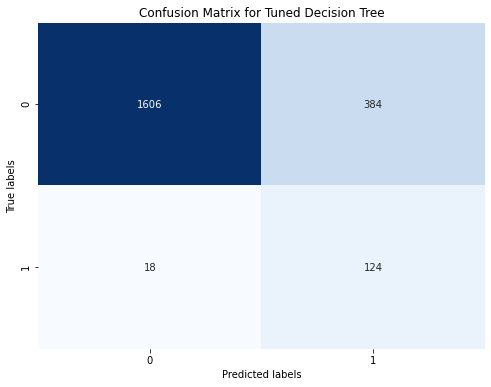

In [28]:
best_model_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=4263
)
best_model_dt.fit(X_train_rus, y_train_rus)
y_pred_dt_best = best_model_dt.predict(X_test)

Models.evaluate_model(y_test, y_pred_dt_best, 'Tuned Decision Tree')

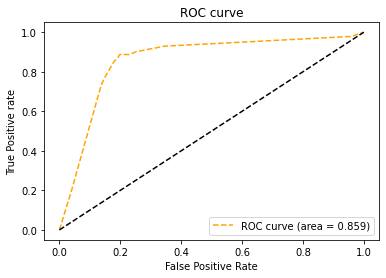

AUC score: 0.859


In [29]:
Models.auc_roc(best_model_dt,'Decision Tree',X_test,y_test)

## XGBoost

In [32]:
#XGBoost classifier initial
model_xgb = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=6,           
    learning_rate=0.1,     
    random_state=4263,    
    scale_pos_weight=1,   
    eval_metric="mlogloss"
)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1990
           1       0.82      0.68      0.75       142

    accuracy                           0.97      2132
   macro avg       0.90      0.84      0.86      2132
weighted avg       0.97      0.97      0.97      2132



{'accuracy': 0.9690431519699813,
 'precision': 0.8220338983050848,
 'recall': 0.6830985915492958,
 'f1_score': 0.7461538461538462}

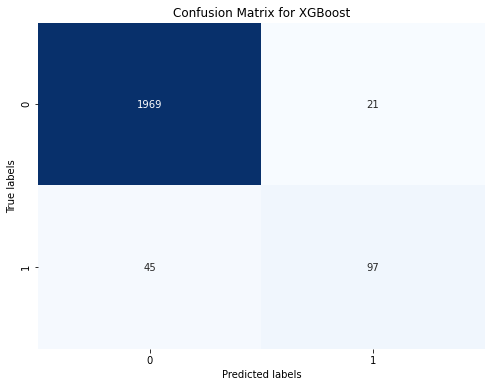

In [33]:
#train
model_xgb.fit(X_train_ros, y_train_ros)

#predictions
y_pred_xgb = model_xgb.predict(X_test)

#evaluations 
Models.evaluate_model(y_test, y_pred_xgb, 'XGBoost')

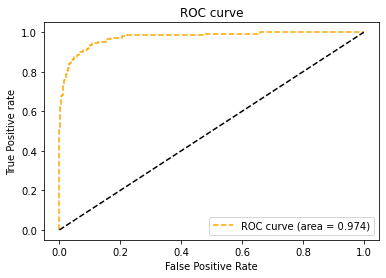

AUC score: 0.974


In [35]:
Models.auc_roc(model_xgb,'XGBoost',X_test,y_test)

## Random Forest (without tuning)

In [27]:
rfc = RandomForestClassifier(random_state = 4263)
rfc.fit(X_train_ros, y_train_ros)
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1990
           1       0.99      0.51      0.68       142

    accuracy                           0.97      2132
   macro avg       0.98      0.76      0.83      2132
weighted avg       0.97      0.97      0.96      2132



{'accuracy': 0.9671669793621013,
 'precision': 0.9864864864864865,
 'recall': 0.5140845070422535,
 'f1_score': 0.675925925925926}

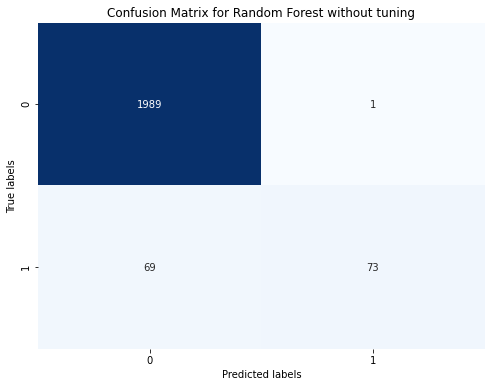

In [28]:
Models.evaluate_model(y_test,y_pred,'Random Forest without tuning')

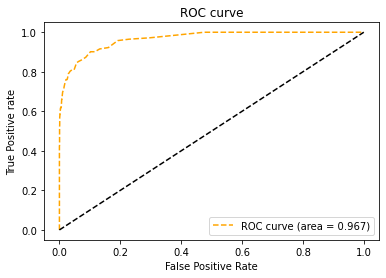

AUC score: 0.967


In [29]:
Models.auc_roc(rfc,'Random Forest without tuning',X_test,y_test)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1990
           1       0.47      0.83      0.60       142

    accuracy                           0.93      2132
   macro avg       0.73      0.88      0.78      2132
weighted avg       0.95      0.93      0.94      2132



{'accuracy': 0.9272983114446529,
 'precision': 0.4738955823293173,
 'recall': 0.8309859154929577,
 'f1_score': 0.6035805626598466}

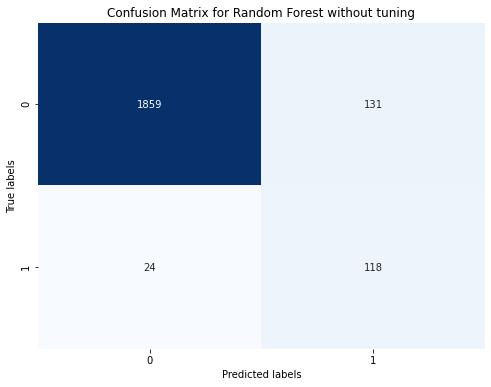

In [30]:
rfc.fit(X_train_rus, y_train_rus)
y_pred = rfc.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Random Forest without tuning')

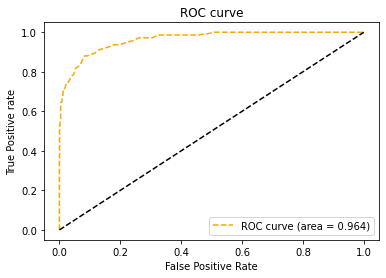

AUC score: 0.964


In [31]:
Models.auc_roc(rfc,'Random Forest without tuning',X_test,y_test)

## Random Forest (with tuning)

In [32]:
rfc = RandomForestClassifier(random_state = 4263, 
                             max_features = 'sqrt',
                             min_samples_leaf = 5,
                             min_samples_split = 5,
                             n_estimators= 100,
                             max_depth = 10, 
                             criterion = 'gini',
                             n_jobs=-1)
rfc.fit(X_train_ros, y_train_ros)
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1990
           1       0.81      0.66      0.73       142

    accuracy                           0.97      2132
   macro avg       0.89      0.83      0.86      2132
weighted avg       0.97      0.97      0.97      2132



{'accuracy': 0.9671669793621013,
 'precision': 0.8103448275862069,
 'recall': 0.6619718309859155,
 'f1_score': 0.7286821705426356}

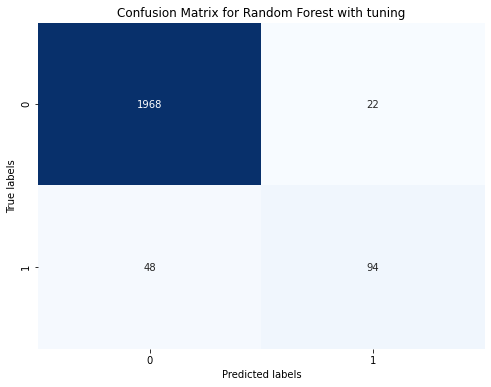

In [33]:
Models.evaluate_model(y_test,y_pred,'Random Forest with tuning')

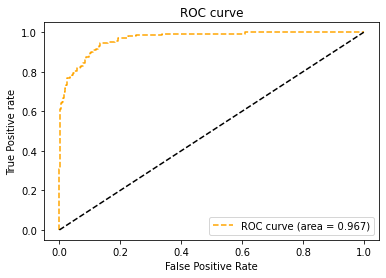

AUC score: 0.967


In [34]:
Models.auc_roc(rfc,'Random Forest with tuning',X_test,y_test)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1990
           1       0.42      0.80      0.55       142

    accuracy                           0.91      2132
   macro avg       0.70      0.86      0.75      2132
weighted avg       0.95      0.91      0.93      2132



{'accuracy': 0.9141651031894934,
 'precision': 0.42379182156133827,
 'recall': 0.8028169014084507,
 'f1_score': 0.5547445255474452}

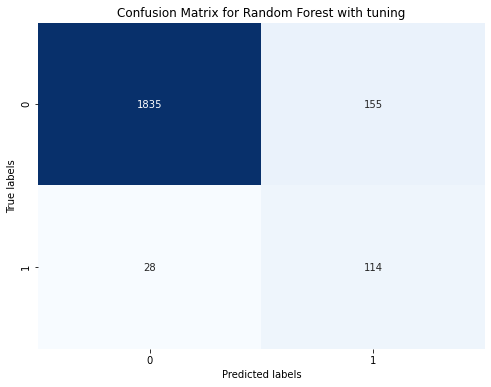

In [35]:
rfc.fit(X_train_rus, y_train_rus)
y_pred = rfc.predict(X_test)
Models.evaluate_model(y_test,y_pred,'Random Forest with tuning')

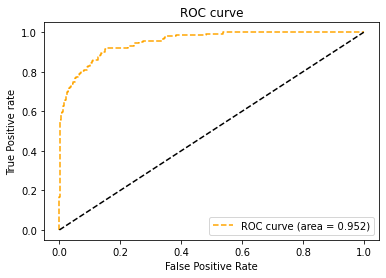

AUC score: 0.952


In [36]:
Models.auc_roc(rfc,'Random Forest with tuning',X_test,y_test)

## Neural Networks

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [38]:
num_features = X_train_ros.shape[1]
print(num_features)

100


In [39]:
# Build the model
nn_model = Sequential([
    Input(shape=(num_features,)),  # Input layer
    Dense(128, activation='relu'), # First hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1, activation='sigmoid') # Output layer (binary classification)
])
optimizer = Adam(learning_rate=0.001)  
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall()])

# Print model summary
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23297 (91.00 KB)
Trainable params: 23297 (91.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
nn_model.fit(X_train_ros,
             y_train_ros,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

Epoch 1/10
496/496 [==============================] - 2s 5ms/step - loss: 2.3810e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.9798 - val_recall: 0.7535
Epoch 2/10
496/496 [==============================] - 3s 5ms/step - loss: 1.6907e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1885 - val_accuracy: 0.9798 - val_recall: 0.7535
Epoch 3/10
496/496 [==============================] - 2s 5ms/step - loss: 1.2561e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9794 - val_recall: 0.7465
Epoch 4/10
496/496 [==============================] - 3s 5ms/step - loss: 9.4502e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1956 - val_accuracy: 0.9794 - val_recall: 0.7465
Epoch 5/10
496/496 [==============================] - 2s 5ms/step - loss: 7.2005e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.9794 - val_recall: 0.7465
Epoch 6/10
496/496 [==============================] - 2s 4ms/step - loss: 5.4562

In [50]:
results = nn_model.evaluate(X_test, y_test)
accuracy = results[1]
recall = results[2]
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

67/67 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9794 - recall: 0.7465
Test Accuracy: 0.9794
Test Recall: 0.7465


In [51]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred).tolist()

67/67 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1990
           1       0.93      0.75      0.83       142

    accuracy                           0.98      2132
   macro avg       0.96      0.87      0.91      2132
weighted avg       0.98      0.98      0.98      2132



{'accuracy': 0.9793621013133208,
 'precision': 0.9298245614035088,
 'recall': 0.7464788732394366,
 'f1_score': 0.8281249999999999}

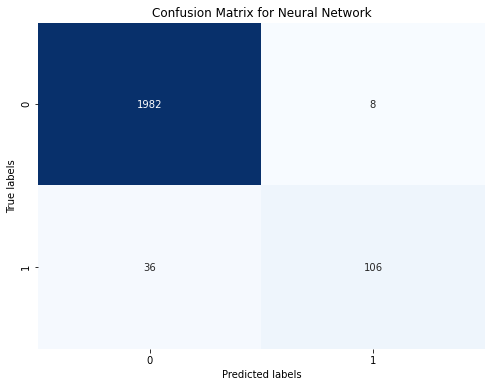

In [52]:
Models.evaluate_model(y_test,y_pred,'Neural Network')

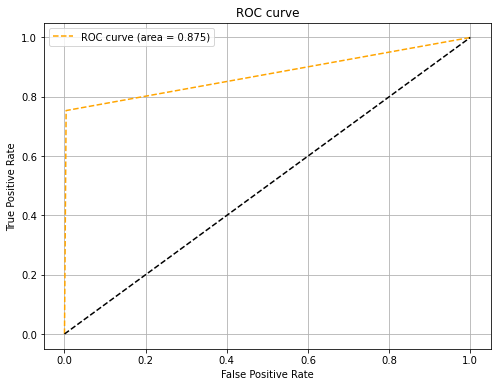

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [45]:
nn_model.fit(X_train_rus,
             y_train_rus,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

Epoch 1/10
37/37 [==============================] - 2s 15ms/step - loss: 3.9151e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1780 - val_accuracy: 0.9794 - val_recall: 0.7535
Epoch 2/10
37/37 [==============================] - 0s 12ms/step - loss: 3.6206e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1781 - val_accuracy: 0.9794 - val_recall: 0.7535
Epoch 3/10
37/37 [==============================] - 0s 12ms/step - loss: 3.3650e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1780 - val_accuracy: 0.9794 - val_recall: 0.7535
Epoch 4/10
37/37 [==============================] - 0s 12ms/step - loss: 3.1640e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1780 - val_accuracy: 0.9794 - val_recall: 0.7535
Epoch 5/10
37/37 [==============================] - 0s 11ms/step - loss: 2.9703e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.1778 - val_accuracy: 0.9794 - val_recall: 0.7535
Epoch 6/10
37/37 [==============================] - 0s 11ms/step - loss: 2.8053e-05 -

In [46]:
results = nn_model.evaluate(X_test, y_test)
accuracy = results[1]
recall = results[2]
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

67/67 [==============================] - 0s 4ms/step - loss: 0.1774 - accuracy: 0.9794 - recall: 0.7535
Test Accuracy: 0.9794
Test Recall: 0.7535


67/67 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1990
           1       0.92      0.75      0.83       142

    accuracy                           0.98      2132
   macro avg       0.95      0.87      0.91      2132
weighted avg       0.98      0.98      0.98      2132



{'accuracy': 0.9793621013133208,
 'precision': 0.9224137931034483,
 'recall': 0.7535211267605634,
 'f1_score': 0.8294573643410852}

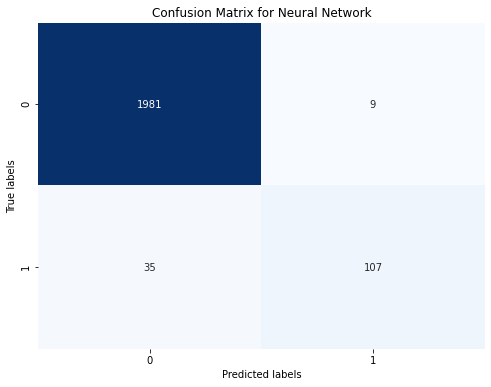

In [47]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred).tolist()
Models.evaluate_model(y_test,y_pred,'Neural Network')

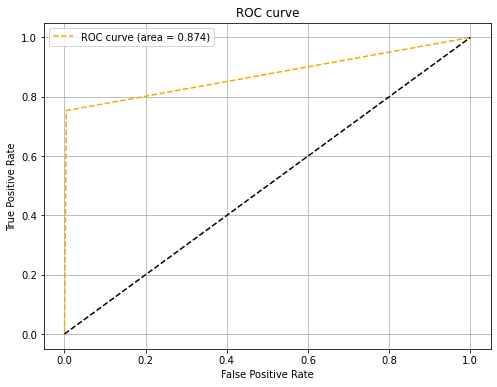

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()